The code is based on kaggle project:
https://www.kaggle.com/code/rajmehra03/flower-recognition-cnn-keras
Flower Recognition CNN Keras, RAJ MEHROTRA, 2019

In [1]:
!git clone https://github.com/j-anne/ML_flower_recognition.git

Cloning into 'ML_flower_recognition'...
remote: Enumerating objects: 3110, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3110 (delta 2), reused 10 (delta 2), pack-reused 3100
Receiving objects: 100% (3110/3110), 150.83 MiB | 30.42 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (3060/3060), done.


Data Preparation

In [2]:
# Getting file path
import os

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
from tqdm import tqdm                
from random import shuffle  
from PIL import Image

**Data Preparation**

In [3]:
train_images = []
train_labels = []

In [4]:
def load_images(DIR):
    for flower in tqdm(os.listdir(DIR)):
      label = flower
      path = DIR +'/'+ flower

      for image in os.listdir(path):
        img = cv2.imread(path+'/'+image)
        img = np.array(img).astype('uint8')
        img = cv2.resize(img, (150, 150))

        train_images.append(img)
        train_labels.append(label)

load_images("/content/ML_flower_recognition/flowers")

100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


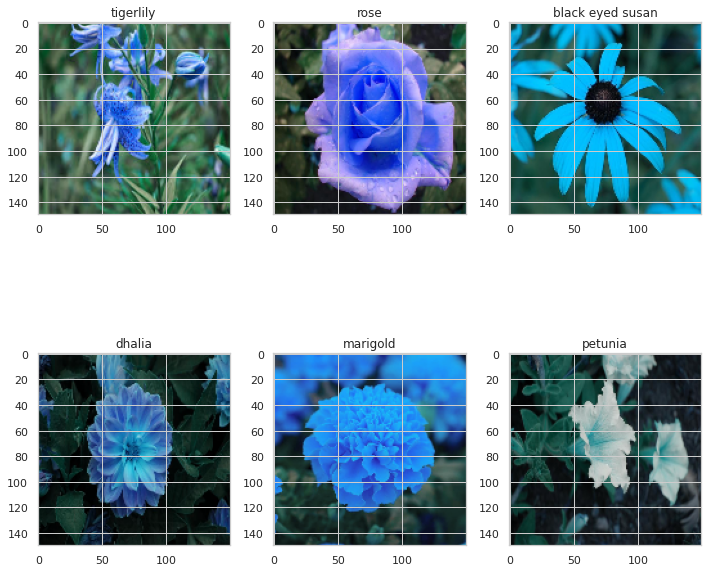

In [5]:
fig,ax=plt.subplots(2,3)
fig.set_size_inches(10,10)
for i in range(2): 
  for j in range (3):
      l=rn.randint(0,len(train_labels))
      ax[i,j].imshow(train_images[l])
      ax[i,j].set_title(train_labels[l])

plt.tight_layout()

**Builing the Model**

In [5]:
# modelling starts using a CNN.
# Uses RELU and Softmax for activation function
# Building convolutional model
model = Sequential()

# Input Layer
model.add(Conv2D(32, kernel_size=(5,5), padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Convolution Layer
model.add(Conv2D(32, kernel_size=(3,3), padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(3,3), padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(96, kernel_size=(3,3), padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3,3), padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Fully connected layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.8))

model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.8))

# Output Layer
model.add(Dense(len(train_images), activation = "softmax"))

In [6]:
# One Hot Encoding
le=LabelEncoder()
encoded_label=le.fit_transform(train_labels)
encoded_label=to_categorical(encoded_label,len(encoded_label))

# using cv2 for normalization
normalize_data = []

for img in train_images:
  norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  normalize_data.append(norm)

normalize_data = np.array(normalize_data)



In [8]:
print(f"Normalize data shape: {normalize_data.shape}")
print(f"Encoded label shape: {encoded_label.shape}")

Normalize data shape: (1692, 150, 150, 3)
Encoded label shape: (1692, 1692)


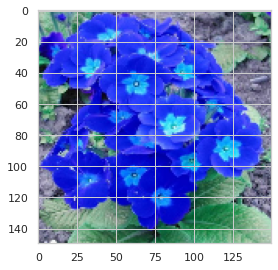

In [9]:
plt.imshow(normalize_data[28])

**Train and Test Datasets**

In [7]:
x_train,x_test,y_train,y_test=train_test_split(normalize_data,encoded_label,test_size=0.25,random_state=42)

In [8]:
# To resolve randomness of the model result
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [9]:
batch_size=60
epochs=100

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

**Data Optimization**

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        horizontal_flip=True)  # randomly flip images horizontally

datagen.fit(x_train)

**Visualization**

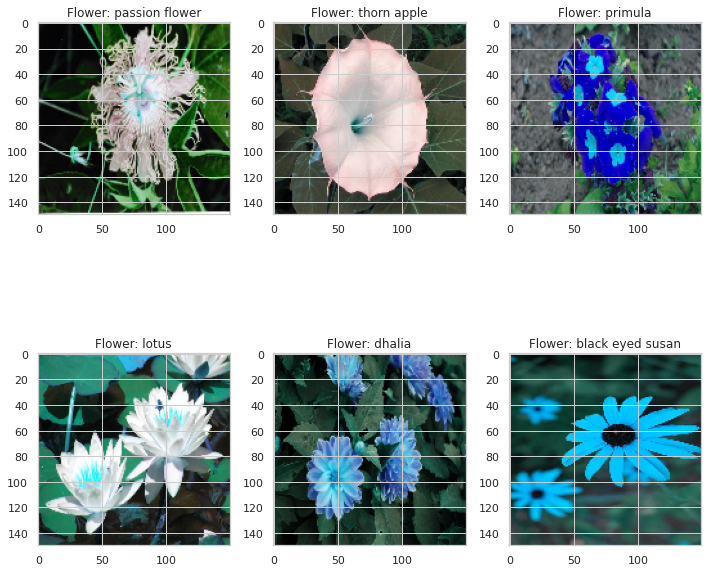

In [11]:
#Creates our batch of one image
fig,ax=plt.subplots(2,3)
fig.set_size_inches(10,10)

for i in range(2): 
  for j in range (3):
      l=rn.randint(0,len(train_labels))
      ax[i,j].imshow(normalize_data[l])
      ax[i,j].set_title('Flower: '+train_labels[l])

plt.tight_layout()

**Fitting the Model**

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [13]:
History = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/100
21/21 [==============================] - 74s 4s/step - loss: 5.2297 - accuracy: 0.0331 - val_loss: 3.3744 - val_accuracy: 0.0260
Epoch 2/100
21/21 [==============================] - 72s 3s/step - loss: 3.5317 - accuracy: 0.0505 - val_loss: 3.2600 - val_accuracy: 0.0496
Epoch 3/100
21/21 [==============================] - 68s 3s/step - loss: 3.2907 - accuracy: 0.0571 - val_loss: 3.1464 - val_accuracy: 0.0260
Epoch 4/100
21/21 [==============================] - 70s 3s/step - loss: 3.2330 - accuracy: 0.0604 - val_loss: 3.1509 - val_accuracy: 0.0615
Epoch 5/100
21/21 [==============================] - 71s 3s/step - loss: 3.1959 - accuracy: 0.0627 - val_loss: 3.0364 - val_accuracy: 0.0260
Epoch 6/100
21/21 [==============================] - 69s 3s/step - loss: 3.1867 - accuracy: 0.0579 - val_loss: 3.0424 - val_accuracy: 0.0615
Epoch 7/100
21/21 [==============================] - 73s 3s/step - loss: 3.1360 - accuracy: 0.0571 - val_loss: 3.0331 - val_accuracy: 0.0615
Epoch 8/100
2

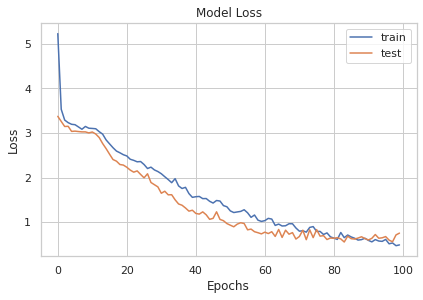

The loss value is:  0.4904528260231018
The val loss value is:  0.7548612356185913


In [14]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

print('The loss value is: ', History.history['loss'][-1])
print('The val loss value is: ', History.history['val_loss'][-1])

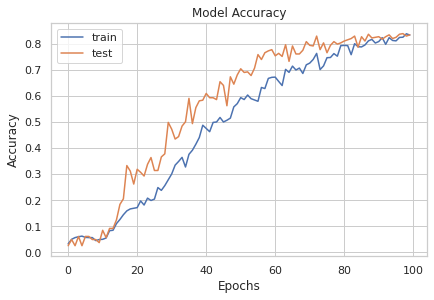

The accuracy of the model is:  83 %
The val accuracy of the model is:  83 %


In [15]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

print('The accuracy of the model is: ', int(History.history['accuracy'][-1] * 100), '%')
print('The val accuracy of the model is: ', int(History.history['val_accuracy'][-1] * 100), '%')

In [16]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

14/14 [==============================] - 7s 454ms/step


In [19]:
# now storing some property as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)

In [20]:
print(f"Count of proper predicted images: {len(prop_class)}")
print(f"Count of mis-predicted images: {len(mis_class)}")

Count of proper predicted images: 353
Count of mis-predicted images: 70


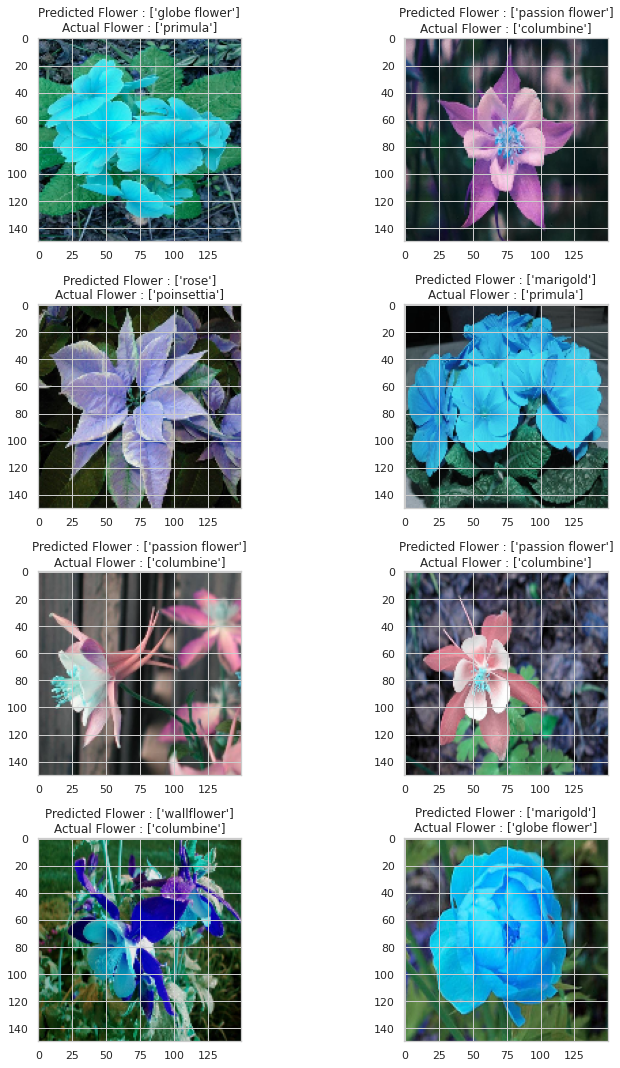

In [21]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range(4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[mis_class[count]])])))
        plt.tight_layout()
        count+=1

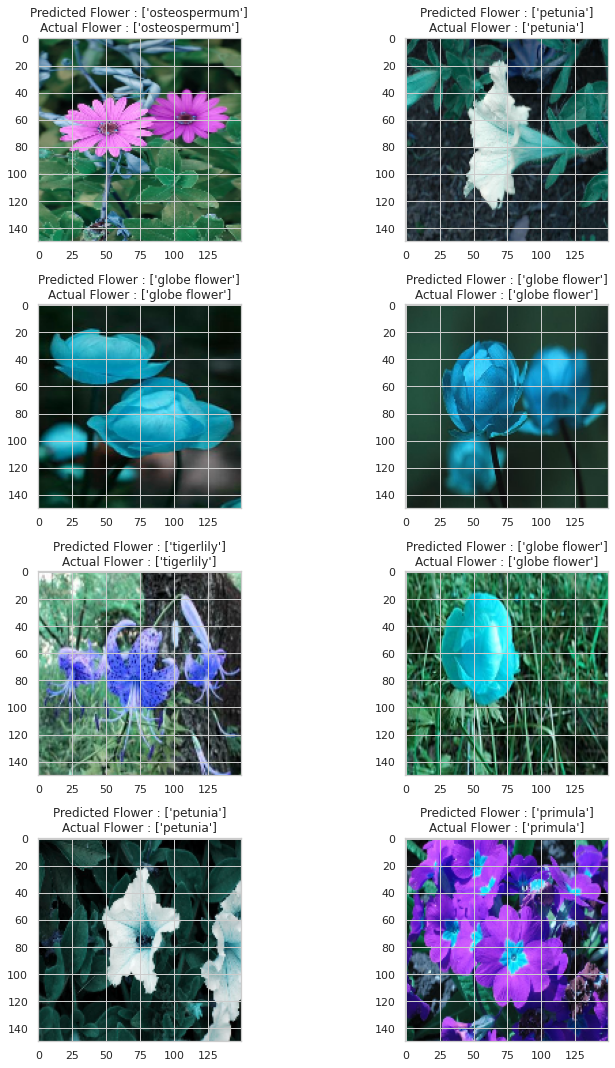

In [22]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[prop_class[count]])])))
        plt.tight_layout()
        count+=1